# Курсовой проект

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import set_config
from Megafon.Course_project.data_manager import DataManager
import Megafon.Course_project.helper as helper
from Megafon.Course_project.metrictool import MetricRegressionManager
from Megafon.Course_project.analyzertool import FeatureAnalyzer

In [17]:
%matplotlib inline
set_config(display='diagram')
plt.style.use('ggplot')

## Константы 

In [18]:
DATA_PATH = r'Megafon\Course_project\temp_data\data_train.csv'      # путь к связи пользователя и целевой переменной
FEATURES_PATH =r'Megafon\Course_project\temp_data\features.csv'     # путь к файлу с опиисанию пользователя
TARGET = 'target'                                                   # целевая переменная
USER_ID = 'id'                                                      # id ползователя
BUY_TIME = 'buy_time_convert'                                       # время регистрации данных
VAS_ID = 'vas_id'                                                   # подключаемая услуга
RANDOM_STATE = 1                                                    # привязка воспроизводимых случайных значениях
RELOAD_DATA_SOURCE = False                                          # True - Необходимо пересобрать обучающую выборуц из csv файлов 

# Управление моделями
# Baseline
BL_MODEL_NAME = 'Baseline'   
RUN_BASELINE = True
# Кросс-валидация на бейзлайне
RUN_CROSS_VALID = True  
# 
BL_UNDER_LOGREG_NAME = 'LogReg feat_proc us'        
RUN_UNDER_LOGREG = True
#
BL_OVER_MODEL_NAME = 'LogReg feat_proc os'
RUN_OVER_LOGREG = True
#
GBC_NAME = 'GradientBoostingClassifier'
RUN_GBC = True
#
RFC_NAME = 'RandomForestClassifier'
RUN_RFC= True

## Глобальные переменные

In [19]:
metric_manager = MetricRegressionManager()

## Обзор датасета 

data_train.csv

| Название | Тип данных | Описание |
| ----------- | ----------- | ----------- |
| id | int64 | Идентификатор абонента |
| vas_id | int64 | Подключаемая услуга  |
| buy_time | int64 | Время покупки, представлено в формате timestamp, для работы с этим столбцом понадобится функция datetime.fromtimestamp из модуля datetime.  |
| target | int64 | Целевая переменная, где 1 означает подключение услуги, 0 - абонент не подключил услугу соответственно.   |

Выборка  фичей для пользователя производится по времени buy_time т.е. не берутся данные пользователя (features) старше времени подключение услуги (target) . T.e features.csv.buy_time должна быть меньше или одного времени data_test.csv.buy_time. Чтобы в следующий раз не пересобирать выборку метод get_full_data позволяет выбрать пересчитывать данные из csv файла или поднять уже ранее сохраненные

In [20]:
source_df:pd.DataFrame = None
if False: # old code. ReadFrom DataSet
    data_manager=DataManager(DATA_PATH, FEATURES_PATH)
    source_df = data_manager.get_full_data(reload_csv = RELOAD_DATA_SOURCE, update_source = RELOAD_DATA_SOURCE)
    source_df = source_df[:6000]                      #! для реальных расчетов убрать 
    source_df.to_csv(r'Megafon\Course_project\source_df.csv')
    source_df.info()
else:
    import zipfile
    with zipfile.ZipFile('Megafon/Course_project/source_df.zip', 'r') as zip_ref:
        zip_ref.extractall('Megafon/Course_project/temp_data')
    source_df = pd.read_csv('Megafon/Course_project/temp_data/source_df.csv')

,index,Unnamed: 0,id,vas_id,target,buy_time_convert,0,1,2,3,...,243,244,245,246,247,248,249,250,251,252
0,0,23,3532789,1.0,0,2018-07-09,-30.349971,-139.569112,-44.290786,-192.176798,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,1,101,167964,4.0,0,2018-07-09,280.330029,47.670888,266.389214,-4.936798,...,-977.373846,-613.770792,-25.996269,-37.630448,-237.747724,-20.832889,-0.694428,-7.175933,-0.45614,0.0
2,2,151,4236220,1.0,0,2018-07-09,-96.799971,49.440888,-110.740786,-3.166798,...,-903.373846,-539.770792,-25.996269,-37.630448,-290.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
3,3,192,3883492,4.0,0,2018-07-09,-92.139971,-46.319112,-106.080786,61.243202,...,-969.373846,-613.770792,-24.996269,-37.630448,1699.252276,-20.832889,1.305572,-9.175933,-0.45614,1.0
4,4,250,2847225,1.0,0,2018-07-09,464.210029,428.250888,450.269214,375.643202,...,6808.626154,6258.229208,-18.996269,58.369552,1.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5995,5995,81483,3687597,1.0,0,2018-07-23,-38.319971,-161.149112,-44.630786,-206.126798,...,-891.373846,-540.770792,-25.996269,7.369552,-201.747724,-16.832889,-0.694428,-3.175933,-0.45614,1.0
5996,5996,81494,3743902,1.0,0,2018-07-23,-56.119971,-235.719112,-70.060786,-280.696798,...,-977.373846,-613.770792,-25.996269,-37.630448,-303.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
5997,5997,81511,2331457,1.0,0,2018-07-23,-96.799971,-111.569112,-110.740786,-138.756798,...,-444.373846,-80.770792,-25.996269,-34.630448,-279.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
5998,5998,81517,2562237,1.0,0,2018-07-23,-69.849971,239.100888,-83.790786,203.453202,...,-977.373846,-613.770792,-25.996269,-34.630448,-303.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0


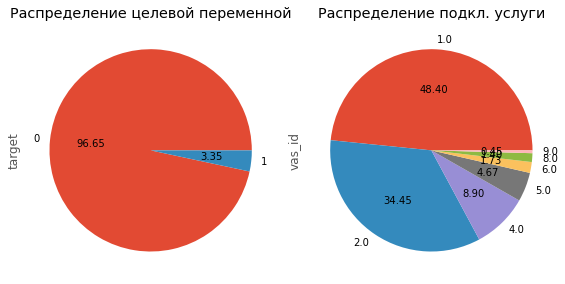

In [21]:
source_df[TARGET] = source_df[TARGET].astype('int')
helper.show_distribution_variables_pie({'Распределение целевой переменной':source_df[TARGET], 'Распределение подкл. услуги':source_df[VAS_ID]})
source_df.reset_index()

In [22]:
helper.print_NaN_data(source_df)

Null-значение отсутствуют


## Определение типа признаков

<ipython-input-23-b2f29124a587>:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  feature_analyzer:FeatureAnalyzer = FeatureAnalyzer(features = source_df.drop([TARGET, USER_ID, BUY_TIME], 1), target=source_df[TARGET])


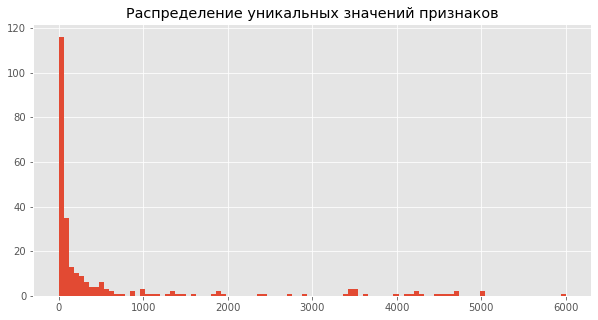

In [23]:
feature_analyzer:FeatureAnalyzer = FeatureAnalyzer(features = source_df.drop([TARGET, USER_ID, BUY_TIME], 1), target=source_df[TARGET])
feature_analyzer.show_feature_unique()
sorted_features = feature_analyzer.share_featres_by_types()

## Делим данные

<ipython-input-24-da649b850c4d>:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train, X_test, y_train, y_test = train_test_split(source_df.drop([TARGET, USER_ID, BUY_TIME], 1), source_df[TARGET], test_size=0.3,  random_state=RANDOM_STATE)


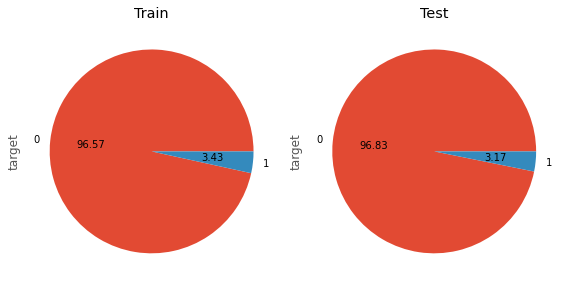

In [24]:
from sklearn.model_selection import train_test_split
X_train:pd.DataFrame = None
X_test:pd.DataFrame = None
y_train:pd.DataFrame = None
y_test:pd.DataFrame = None
X_train, X_test, y_train, y_test = train_test_split(source_df.drop([TARGET, USER_ID, BUY_TIME], 1), source_df[TARGET], test_size=0.3,  random_state=RANDOM_STATE)
helper.show_distribution_variables_pie({'Train':y_train, 'Test':y_test})

## Пайплайн

In [25]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import set_config
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from Megafon.Course_project.helper_evaluating_model import show_roc_auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from Megafon.Course_project.transformers import ColumnSelector

set_config(display='diagram')

### Опишим ряд функций которые понядобятся позже

In [26]:
def model_research(name_estimator:str, estimator: Pipeline, df_x:pd.DataFrame, df_y:pd.Series):
    estimator.fit(df_x, df_y)
    y_pred = estimator.predict_proba(X_test)[:,1]
    metric_manager.apply(name_estimator, y_test, y_pred)

In [27]:
def get_undersampler():
    target_counts = y_train.value_counts()[1]
    rus :RandomUnderSampler = RandomUnderSampler(sampling_strategy={0:target_counts*2, 1:target_counts}, random_state=RANDOM_STATE)
    return rus.fit_sample(X_train, y_train)

def get_oversampler():
    ros = RandomOverSampler(sampling_strategy=0.95, random_state=RANDOM_STATE)
    return ros.fit_sample(X_train, y_train)

### Baseline

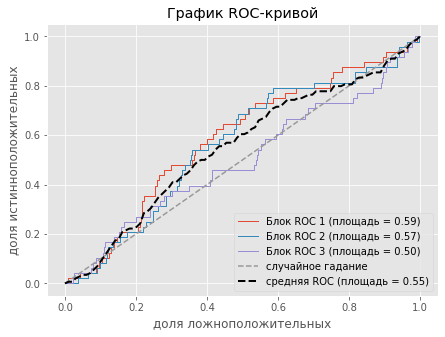

In [28]:
bl_estimator = Pipeline([
    ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])
if RUN_BASELINE: model_research(BL_MODEL_NAME, bl_estimator, X_train, y_train)

# значение метрики на кросс-валидации
if RUN_CROSS_VALID: show_roc_auc(X_train, y_train, bl_estimator)


По результату Roc-AUC видно что бейзлайн ничем не лучше обычного гадания. Попробуем посмотреть что поменяется если обработать немного данные

### Определимся с предобработкой данных

In [29]:
# %%
preprocessor = make_pipeline(
    ColumnSelector(columns=list(sorted_features.categorical | sorted_features.numeric)),
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            ColumnSelector(list(sorted_features.numeric)),
            SimpleImputer(strategy="mean"),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            ColumnSelector(list(sorted_features.categorical)),
            SimpleImputer(strategy="most_frequent"),
            OneHotEncoder(handle_unknown='ignore')
        ))
        # ("boolean_features", make_pipeline(
        #     ColumnSelector(f_binary),
        # ))
    ])
)

### Посмотрим как модель себя покажет с oversampling и undersampling

Т.к. есть перекос на целевой переменной(подключивших услуги и не подключивших) попробуем немного выровнять эти показатели

In [30]:
bl_over_estimator = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])
if RUN_OVER_LOGREG:
    X_res, y_res =get_oversampler()
    model_research(BL_OVER_MODEL_NAME, bl_over_estimator, X_res, y_res)
    

In [31]:
bl_under_estimator = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1))
])
if RUN_UNDER_LOGREG:
    X_res, y_res =get_undersampler()
    model_research(BL_UNDER_LOGREG_NAME, bl_under_estimator, X_res, y_res)

### Посмотрим результаты

c:\Work\Lesson\gb_develop\Megafon\Course_project\metrictool.py:58: RuntimeWarning: invalid value encountered in longlong_scalars
  return self.TP/(self.TP+self.FP)
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control thi

Confusion matrix, without normalization


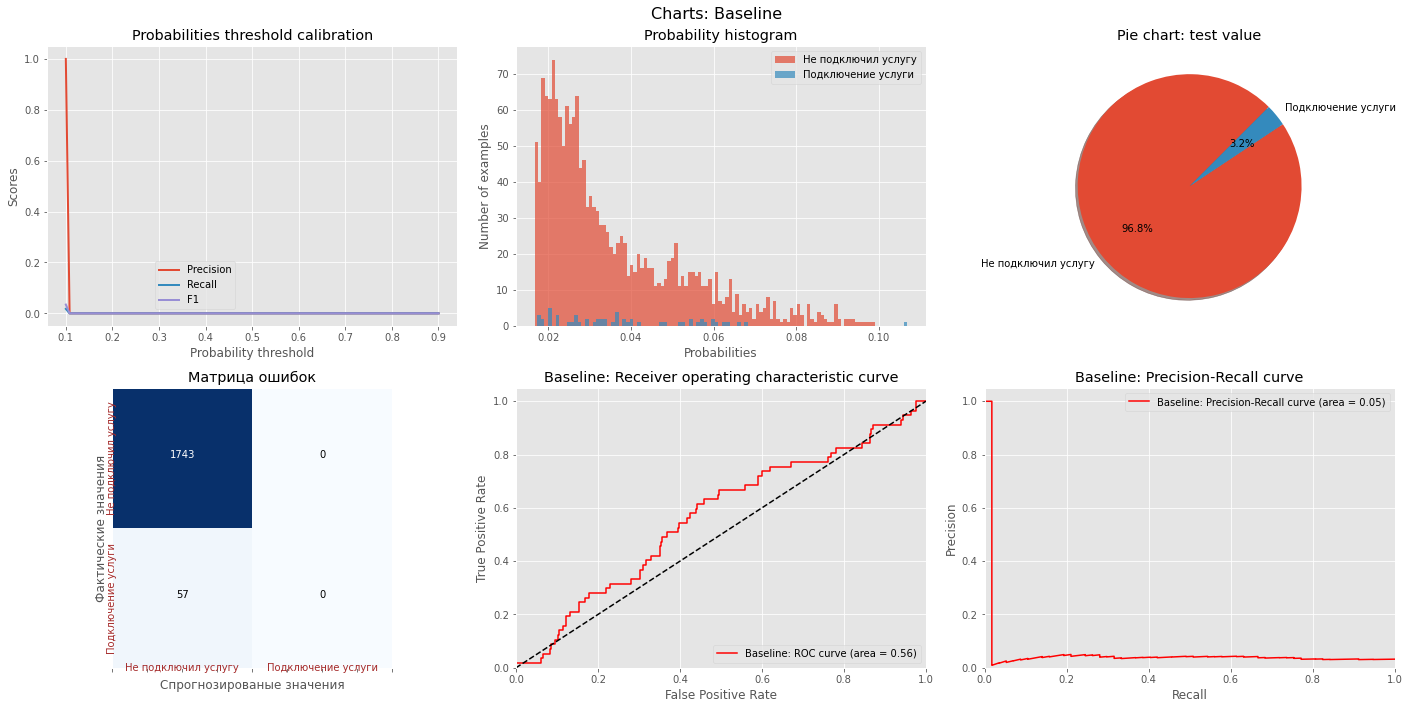

Confusion matrix, without normalization


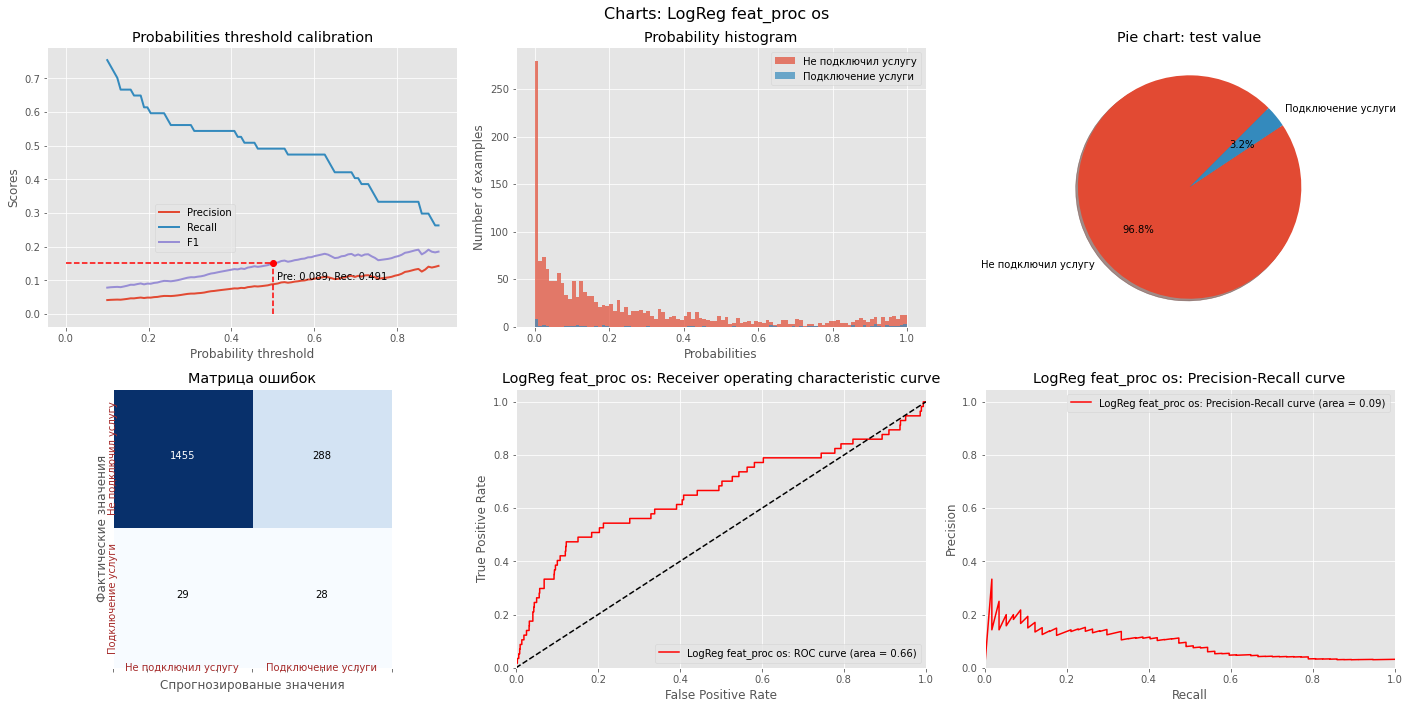

Confusion matrix, without normalization


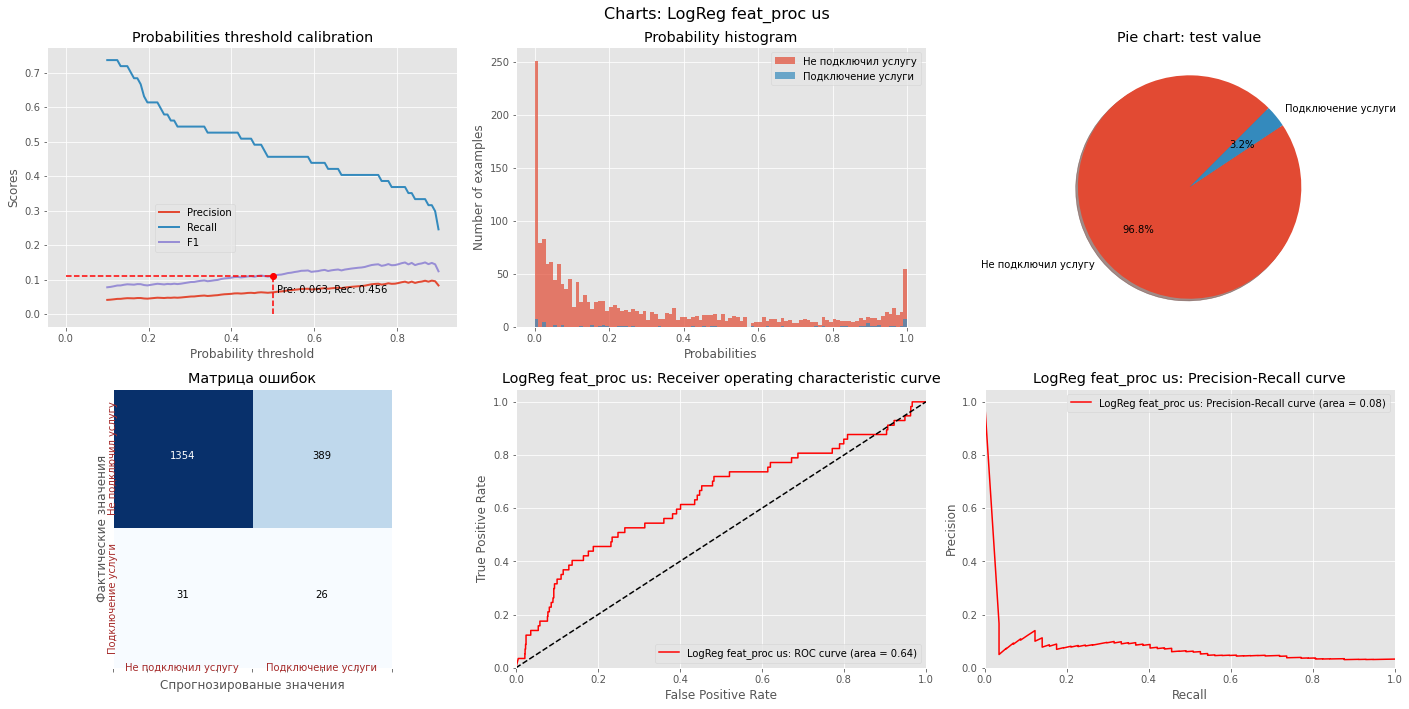

Name model             Threshold    F-Score    Precision    Recall    Roc-AUC    f1-score(macro)
-------------------  -----------  ---------  -----------  --------  ---------  -----------------
Baseline                     0.5     nan         nan         0          0.564              0.492
LogReg feat_proc os          0.5       0.15        0.089     0.491      0.66               0.526
LogReg feat_proc us          0.5       0.11        0.063     0.456      0.64               0.488


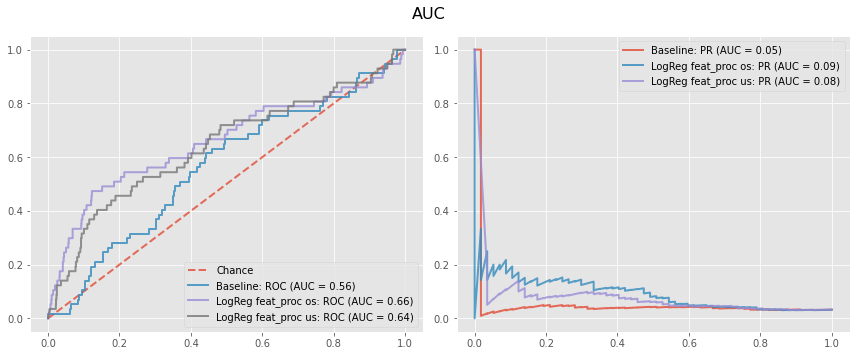

In [32]:
metric_manager.show_full_report(
    name_negative = 'Не подключил услугу',
    name_positive = 'Подключение услуги',
    spec_thr=0.5
)

metric_manager.show_united_auc()

По результату видно улучшение предсказывания целевой перерменной. Т.к. undersampler и oversampler не особо отличаются, для работы возьмем undersampler, что надеюсь съэкономт немного памяти на пк. Treshold взял 0.5, т.к. не получается максимизировать f1-score. Но по графику Probability histogram видно некоторое разделение для определения целевой переменной  

### Поиск параметров для моделей

In [33]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.metrics import f1_score, make_scorer

In [34]:
if False:
    hyperparameters = dict(log_reg__C=uniform(loc=0, scale=4), log_reg__penalty=['l2', 'l1'])
    clf = RandomizedSearchCV(bl_under_estimator, hyperparameters, random_state=RANDOM_STATE, n_iter=50, cv=5, verbose=0, n_jobs=-1, scoring=make_scorer(f1_score, average='macro'))
    X_res, y_res =get_undersampler()
    search = clf.fit(X_res, y_res)
    print(search.best_params_)

т.к. считает долго сохраним ранее полученые результаты отдельно

{'log_reg__C': 2.1326611398920683, 'log_reg__penalty': 'l2'}

### Отбор признаков в пайплайнах

In [35]:
from sklearn.feature_selection import SelectFromModel

fs_pipe = make_pipeline(
    preprocessor,
    SelectFromModel(LogisticRegression(penalty='l2', C=2.133, random_state=RANDOM_STATE), threshold=1e-5),
)
preprocessor.fit(X_train)
fs_pipe.fit(X_train, y_train)
num_insignificant_features = preprocessor.transform(X_test).shape[1] - fs_pipe.transform(X_test).shape[1]
print('Логистическая регрессия из SelectFromModel обнулила около {insign:.3f}% признаков.'.format(insign=num_insignificant_features/preprocessor.transform(X_test).shape[1] * 100))


Логистическая регрессия из SelectFromModel обнулила около 1.575% признаков.


c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Определимся с моделью для логической регрессии

In [36]:
logreg_configured_estimator = Pipeline([
    ('preprocessor', preprocessor),
    ('log_reg', LogisticRegression(penalty='l2', C=1.253, random_state=RANDOM_STATE, n_jobs=-1))
])
if RUN_UNDER_LOGREG:
    X_res, y_res =get_undersampler()
    model_research(BL_UNDER_LOGREG_NAME, bl_under_estimator, X_res, y_res)

## Модель на основе бустинга

In [37]:
if RUN_GBC and False:
    gbc_estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('gbc', GradientBoostingClassifier(random_state=RANDOM_STATE))
    ])

    hyperparameters = dict(
        gbc__max_depth=[3,6,10],
        gbc__n_estimators=[100,500,1000, 1200, 1500],
        gbc__min_samples_split=[2,5,8,11],
        gbc__learning_rate=[0.01,0.05,0.1,0.5,1.0],
        gbc__max_features=['sqrt', 'log2']
        )
    clf = RandomizedSearchCV(
        gbc_estimator, 
        hyperparameters, 
        n_iter = 100, 
        cv = 5, 
        random_state=RANDOM_STATE, 
        verbose=0, n_jobs=-1, scoring=make_scorer(f1_score, average='macro'))
    X_res, y_res =get_undersampler()
    search = clf.fit(X_res, y_res)
    print(search.best_params_)

т.к. считает долго сохраним ранее полученые результаты отдельно

{'gbc__n_estimators': 1500, 'gbc__min_samples_split': 5, 'gbc__max_features': 'sqrt', 'gbc__max_depth': 3, 'gbc__learning_rate': 0.01}

In [38]:
if RUN_GBC:
    gbc_estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('gbc', GradientBoostingClassifier(
            n_estimators = 1500,
            min_samples_split = 5,
            max_features= 'sqrt',
            max_depth = 3,
            learning_rate = 0.01,
            random_state=RANDOM_STATE))
    ])
    X_res, y_res =get_undersampler()
    model_research(GBC_NAME, gbc_estimator, X_res, y_res)

## Модель на основе Случайного леса

In [39]:
if RUN_RFC and False:
    rfg_estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('rfc', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))
    ])

    hyperparameters = dict(
        rfc__n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
                        rfc__max_features = ['log2', 'sqrt'],
                        rfc__max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)],
                        rfc__min_samples_split = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
                        rfc__min_samples_leaf = [int(x) for x in np.linspace(start = 2, stop = 50, num = 10)],
                        rfc__bootstrap = [True, False]
                        )
    clf = RandomizedSearchCV(rfg_estimator, 
                            hyperparameters, 
                            n_iter = 100, 
                            cv = 5, 
                            random_state=RANDOM_STATE, 
                            verbose=0, n_jobs=-1, scoring=make_scorer(f1_score, average='macro'))
    X_res, y_res =get_undersampler()
    search = clf.fit(X_res, y_res)
    print(search.best_params_)

т.к. считает долго сохраним ранее полученые результаты отдельно

{'rfc__n_estimators': 900, 'rfc__min_samples_split': 28, 'rfc__min_samples_leaf': 2, 'rfc__max_features': 'sqrt', 'rfc__max_depth': 14, 'rfc__bootstrap': False}

In [40]:
if RUN_RFC:
    rfg_estimator = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestClassifier(
            n_estimators = 900,
            min_samples_split = 28,
            min_samples_leaf = 2,
            max_features = 'sqrt',
            max_depth = 14,
            bootstrap = False,
            random_state=RANDOM_STATE, n_jobs=-1))
    ])
    X_res, y_res =get_undersampler()
    model_research(RFC_NAME, rfg_estimator, X_res, y_res)

### Сравним наши модели

c:\Work\Lesson\gb_develop\Megafon\Course_project\metrictool.py:58: RuntimeWarning: invalid value encountered in longlong_scalars
  return self.TP/(self.TP+self.FP)
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control thi

Confusion matrix, without normalization


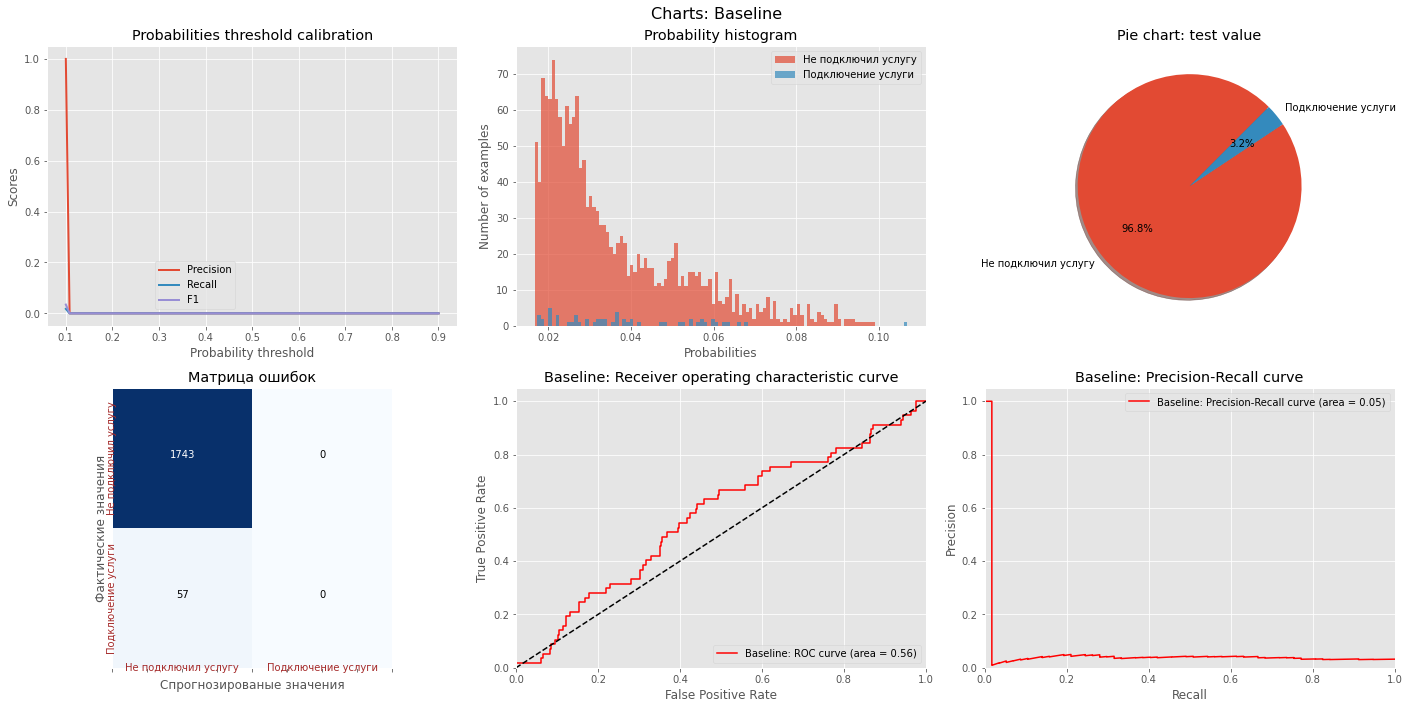

Confusion matrix, without normalization


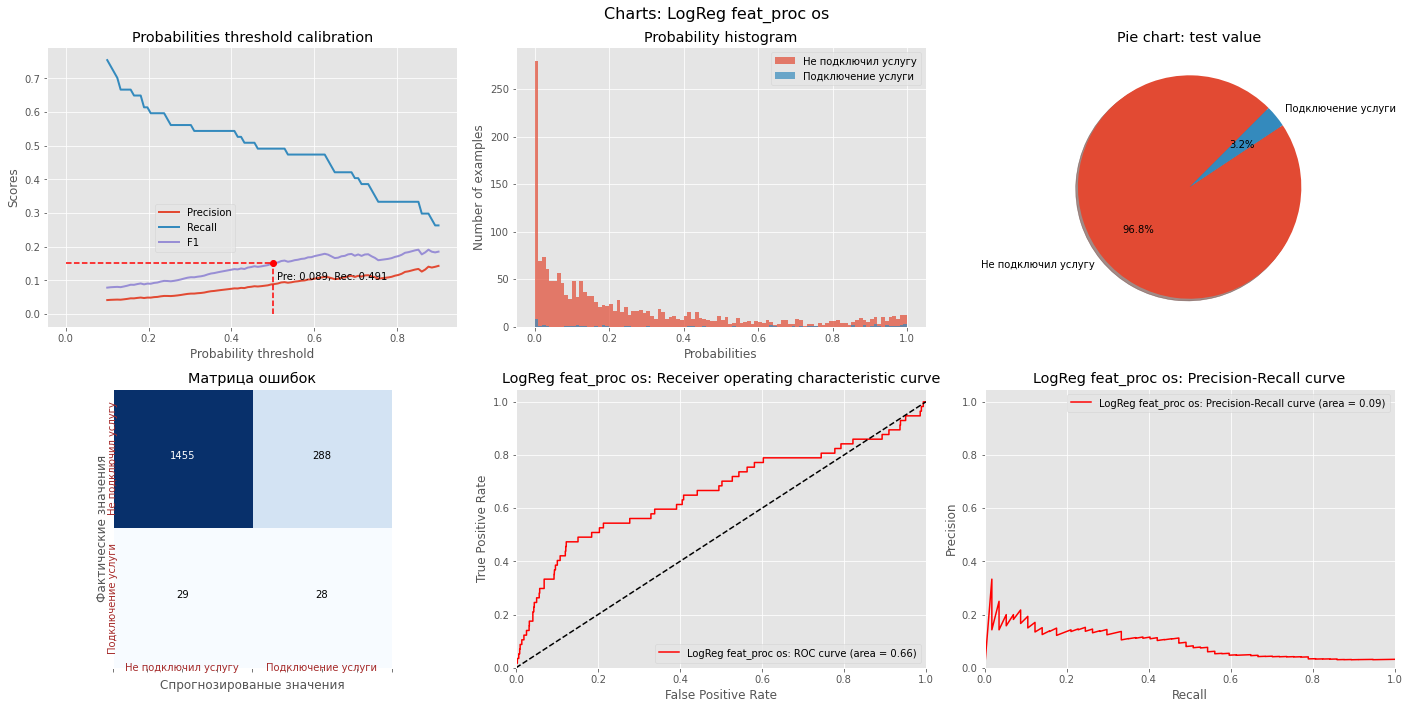

Confusion matrix, without normalization


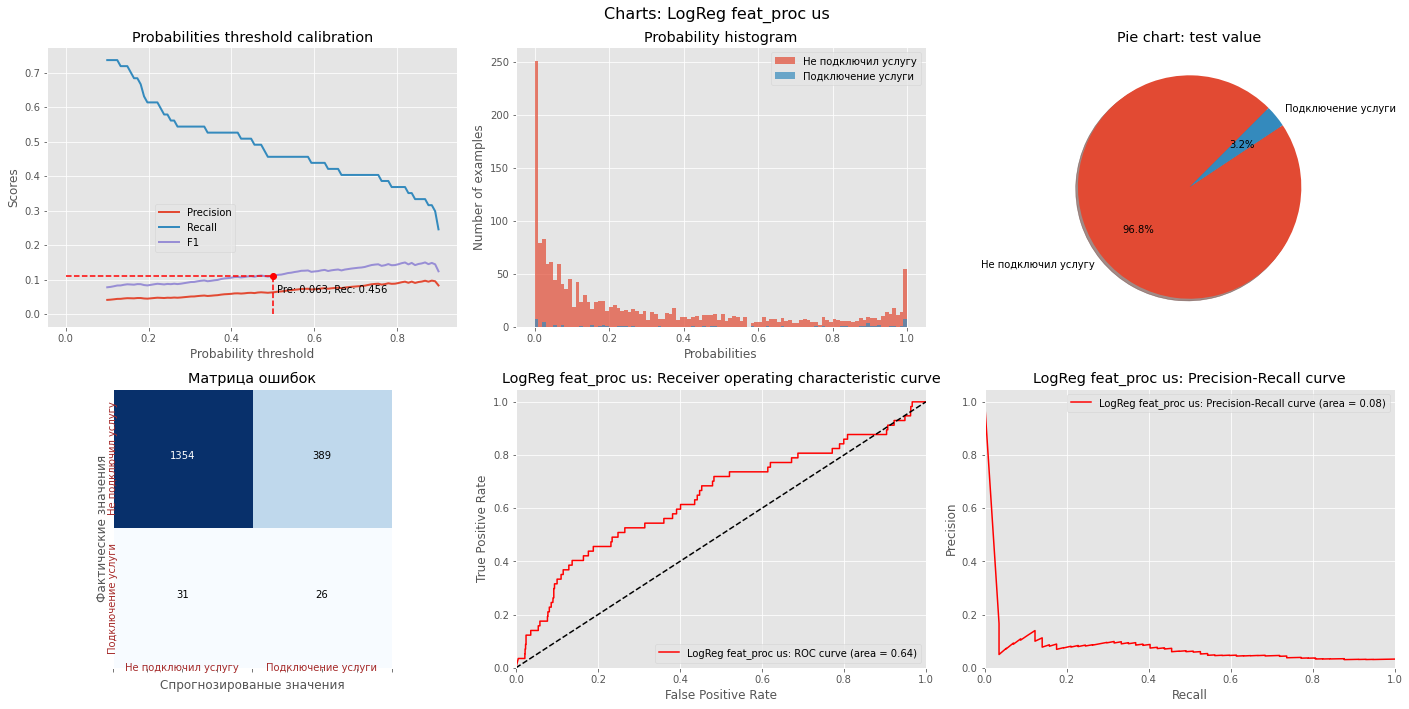

Confusion matrix, without normalization


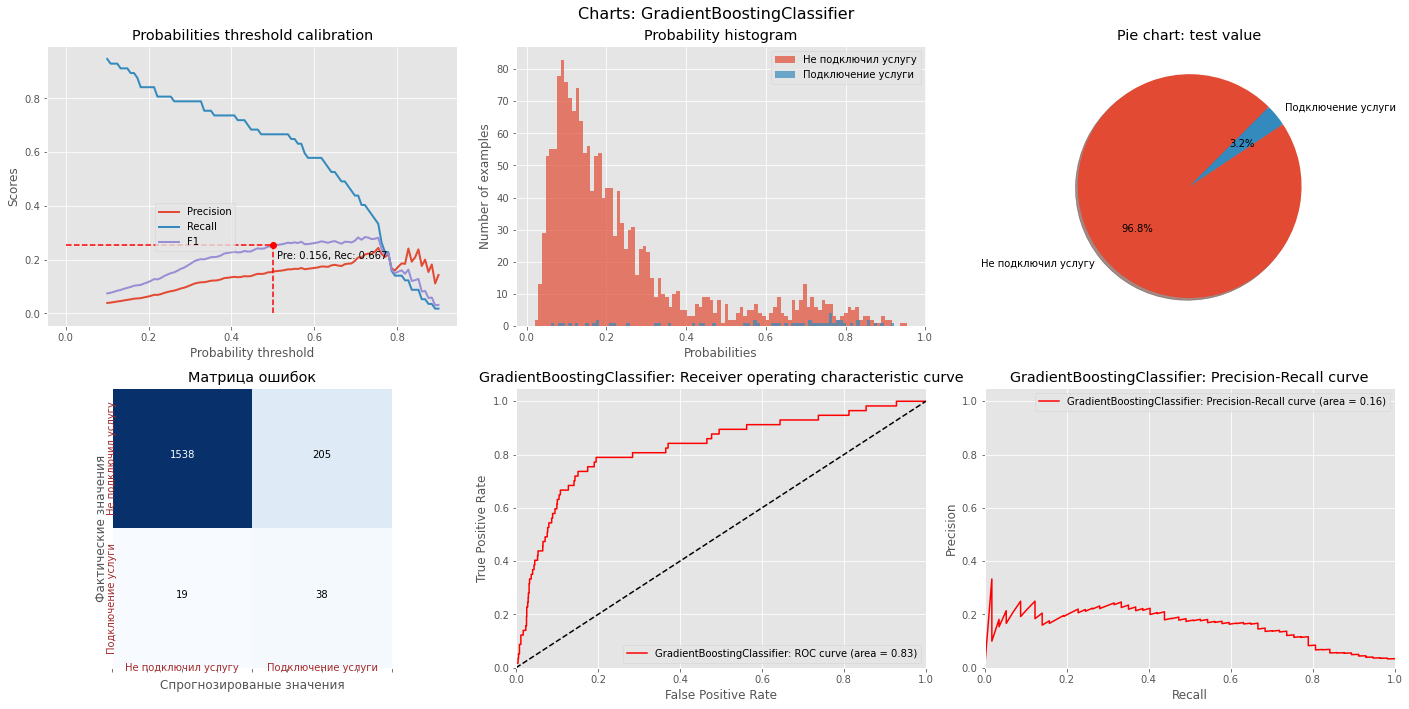

c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: Undefi

Confusion matrix, without normalization


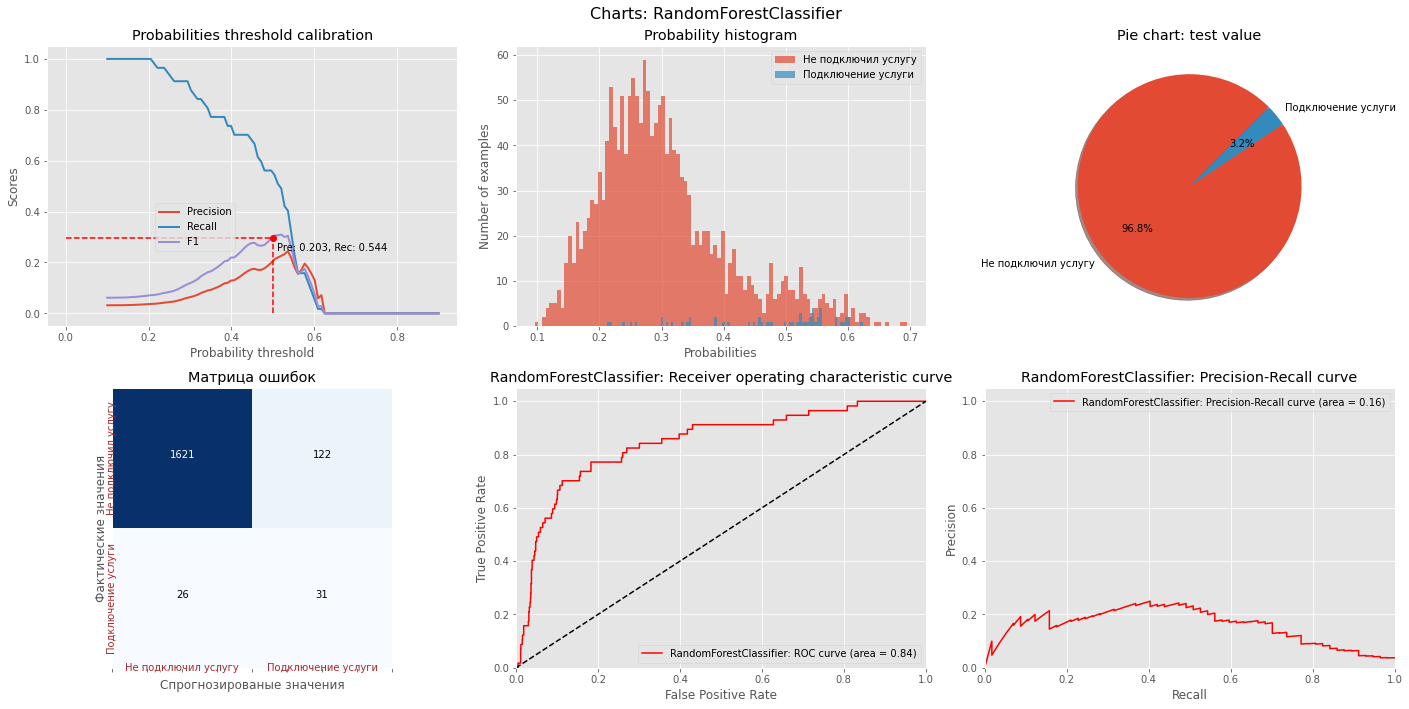

Name model                    Threshold    F-Score    Precision    Recall    Roc-AUC    f1-score(macro)
--------------------------  -----------  ---------  -----------  --------  ---------  -----------------
Baseline                            0.5    nan          nan         0          0.564              0.492
LogReg feat_proc os                 0.5      0.15         0.089     0.491      0.66               0.526
LogReg feat_proc us                 0.5      0.11         0.063     0.456      0.64               0.488
GradientBoostingClassifier          0.5      0.253        0.156     0.667      0.826              0.593
RandomForestClassifier              0.5      0.295        0.203     0.544      0.844              0.626


c:\Work\Lesson\gb_develop\Megafon\Course_project\metrictool.py:249: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
c:\Work\Lesson\gb_develop\Megafon\Course_project\metrictool.py:249: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
c:\Work\Lesson\gb_develop\Megafon\Course_project\metrictool.py:249: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and bei

Confusion matrix, without normalization


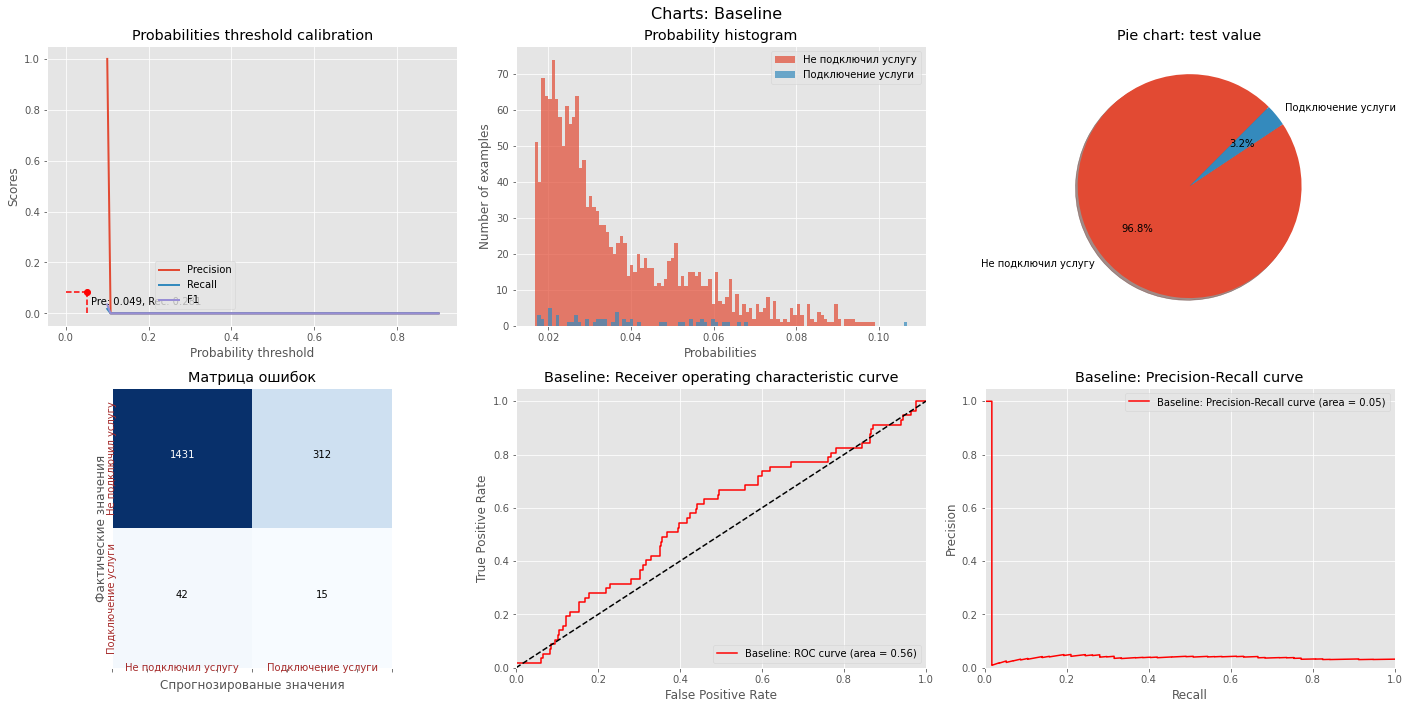

Confusion matrix, without normalization


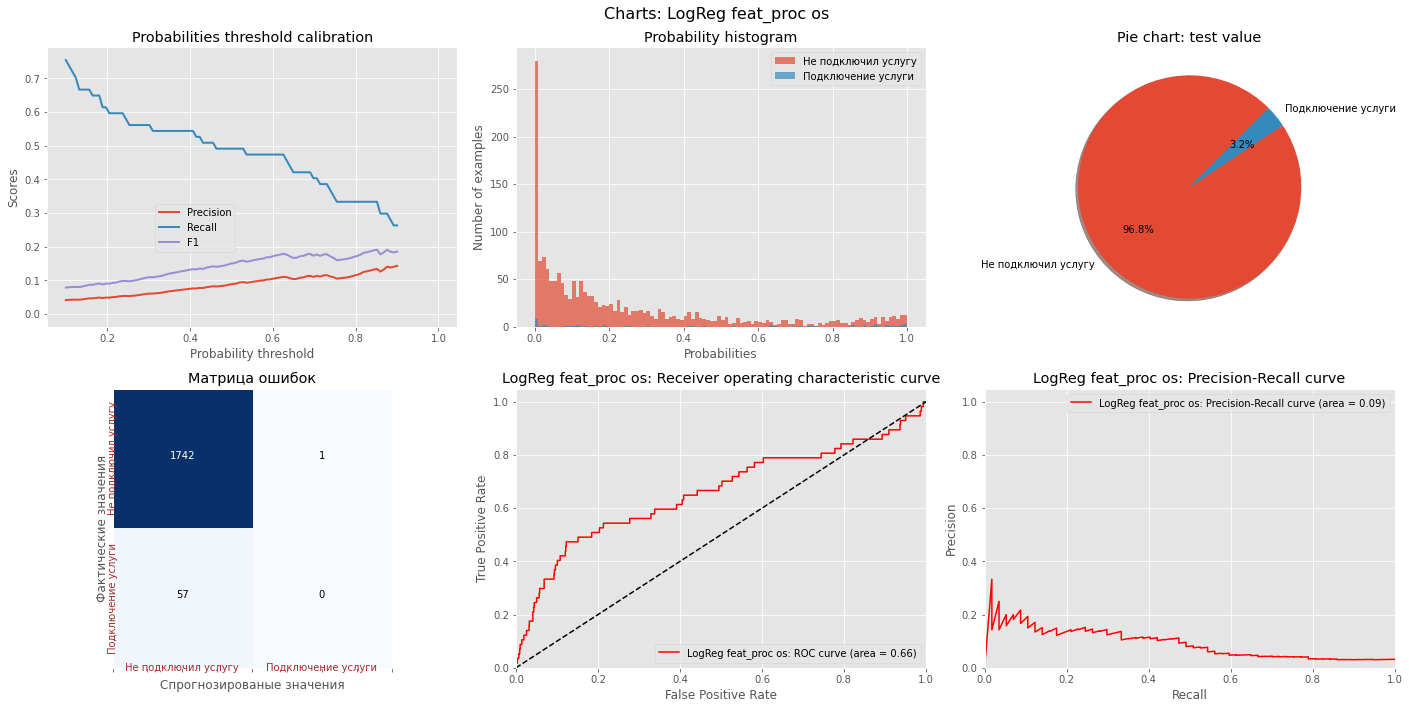

Confusion matrix, without normalization


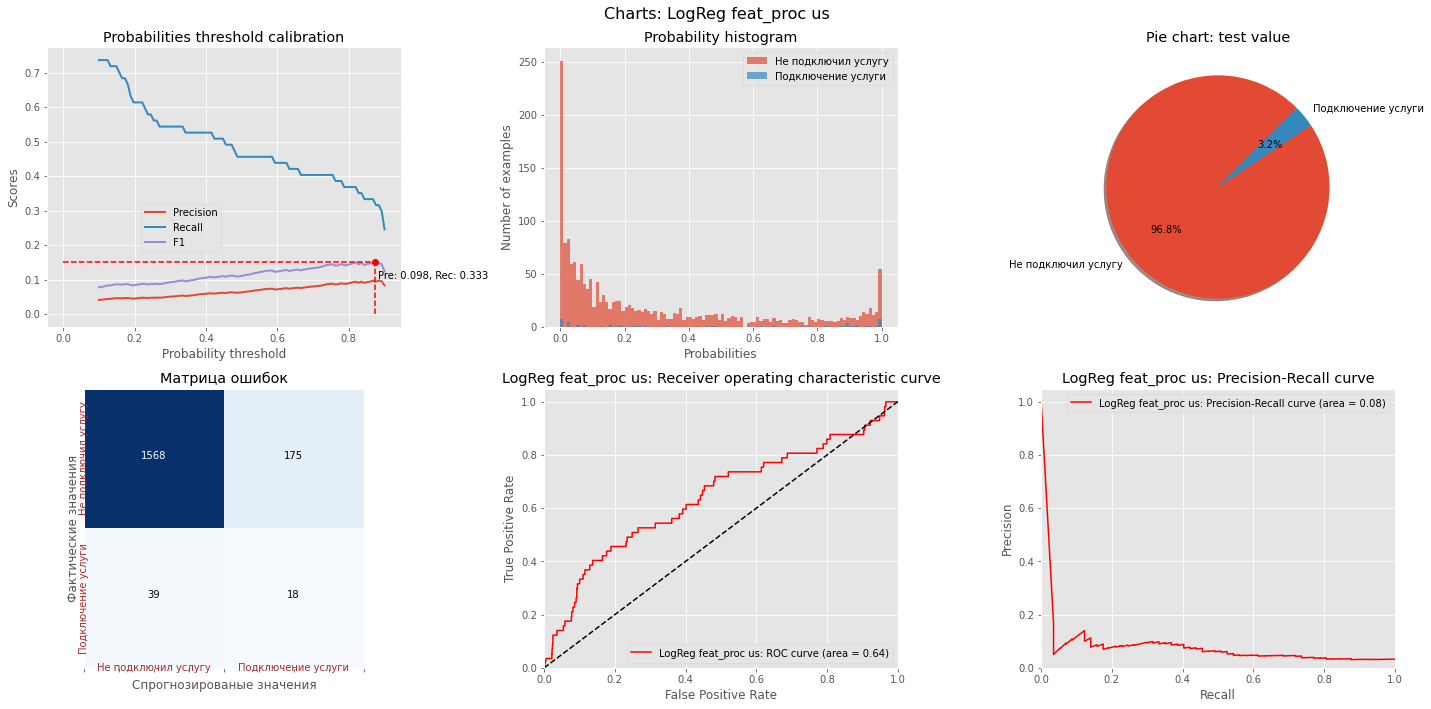

Confusion matrix, without normalization


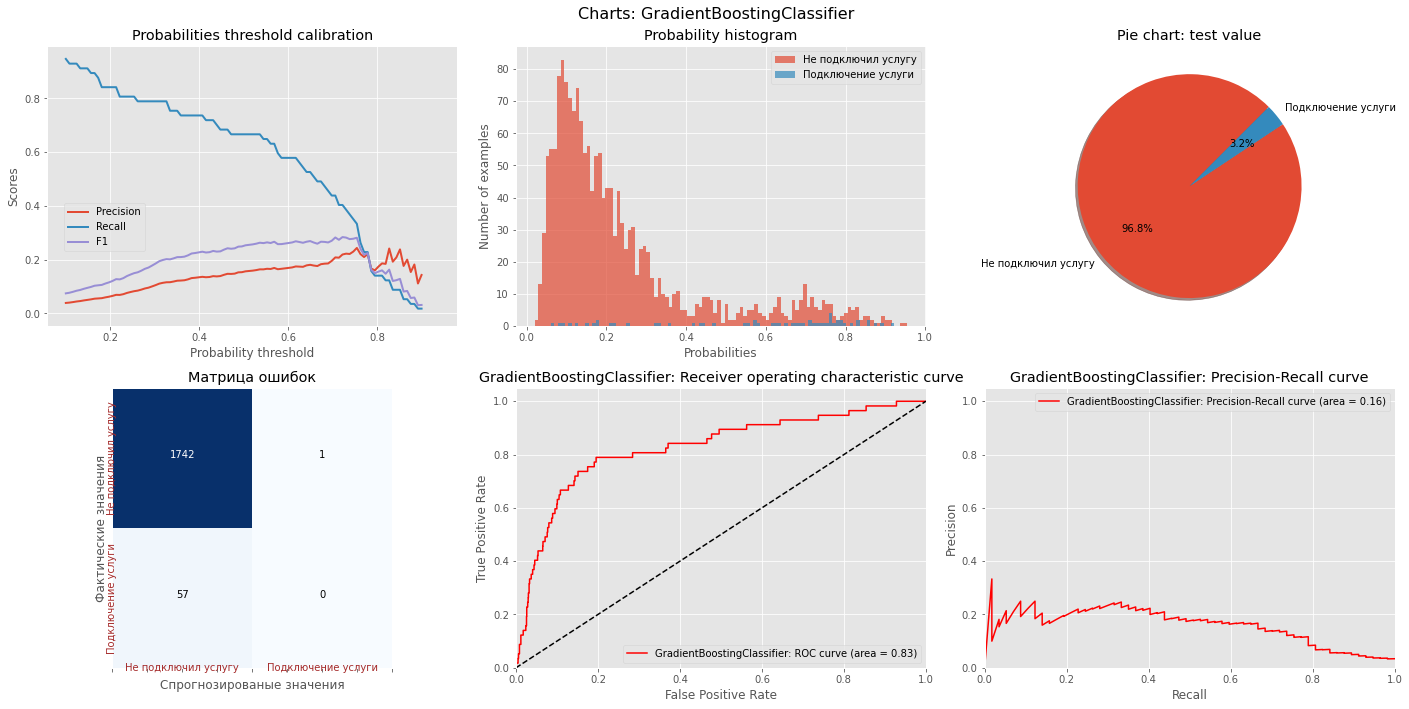

c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Work\Lesson\gb_develop\.venv\lib\site-packages\sklearn\metrics\_classification.py:1245: Undefi

Confusion matrix, without normalization


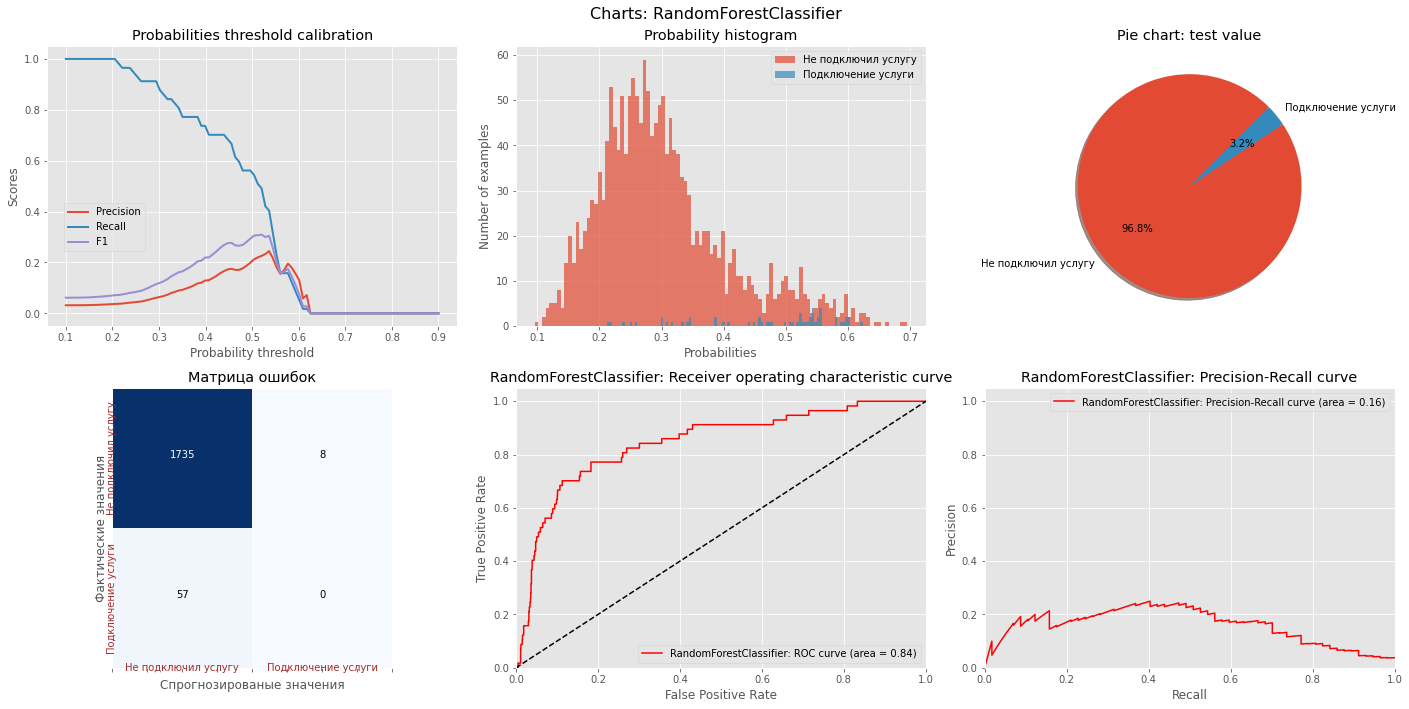

Name model                    Threshold    F-Score    Precision    Recall    Roc-AUC    f1-score(macro)
--------------------------  -----------  ---------  -----------  --------  ---------  -----------------
Baseline                          0.051      0.083        0.049     0.281      0.564              0.484
LogReg feat_proc os               1        nan            0         0          0.66               0.492
LogReg feat_proc us               0.872      0.151        0.098     0.333      0.64               0.54
GradientBoostingClassifier        0.938    nan            0         0          0.826              0.492
RandomForestClassifier            0.625    nan            0         0          0.844              0.491


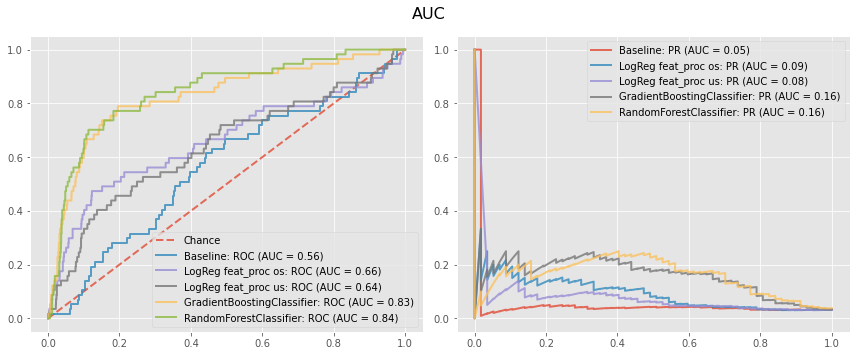

In [41]:
metric_manager.show_full_report(
    name_negative = 'Не подключил услугу',
    name_positive = 'Подключение услуги',
    spec_thr=0.5
)

metric_manager.show_full_report(
    name_negative = 'Не подключил услугу',
    name_positive = 'Подключение услуги'
)

metric_manager.show_united_auc()

При Threshold = 0.5 лучший результат показал случайный лес. Его и выбирем за основную модель.

In [42]:
import joblib

source_df.drop([TARGET, USER_ID, BUY_TIME], 1), source_df[TARGET]
X_res, y_res =get_oversampler()
model_research('final_model', rfg_estimator, source_df.drop([TARGET, USER_ID, BUY_TIME], 1), source_df[TARGET])
joblib.dump(rfg_estimator, 'temp_model.pkl')

<ipython-input-42-36bc0a9ccfa6>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  source_df.drop([TARGET, USER_ID, BUY_TIME], 1), source_df[TARGET]
<ipython-input-42-36bc0a9ccfa6>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  model_research('final_model', rfg_estimator, source_df.drop([TARGET, USER_ID, BUY_TIME], 1), source_df[TARGET])


['temp_model.pkl']

In [43]:
import pickle

with open('temp_model_rfg.pkl', 'wb') as handle:
    pickle.dump(rfg_estimator, handle, protocol=pickle.HIGHEST_PROTOCOL)